# Part 1: Model Training

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Use GPU on Macbook

Reference: https://github.com/mrdbourke/m1-machine-learning-test

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("List of Physical Devices:", tf.config.list_physical_devices())

TensorFlow version: 2.16.2
List of Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def get_class_paths(path): 
    classes=[]
    class_paths=[]

    for label in os.listdir(path): 
        label_path = os.path.join(path, label)

        if os.path.isdir(label_path): 
            for image in os.listdir(label_path): 
                image_path = os.path.join(label_path, image)

                classes.append(label)
                class_paths.append(image_path)

    df = pd.DataFrame({
        'Class Path': class_paths, 
        'Class': classes
    })
    
    return df

In [5]:
tr_df = get_class_paths("Training")
tr_df

,Class Path,Class
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


In [6]:
ts_df = get_class_paths("Testing")
ts_df

,Class Path,Class
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


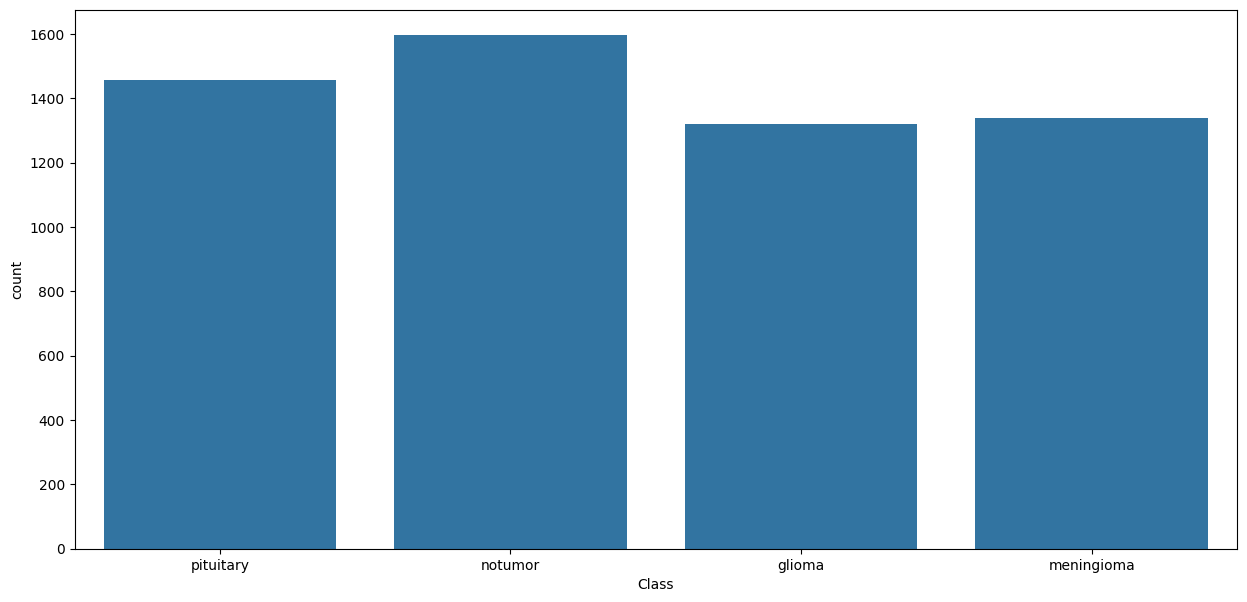

In [7]:
# Display data in training, testing dataset. 
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])

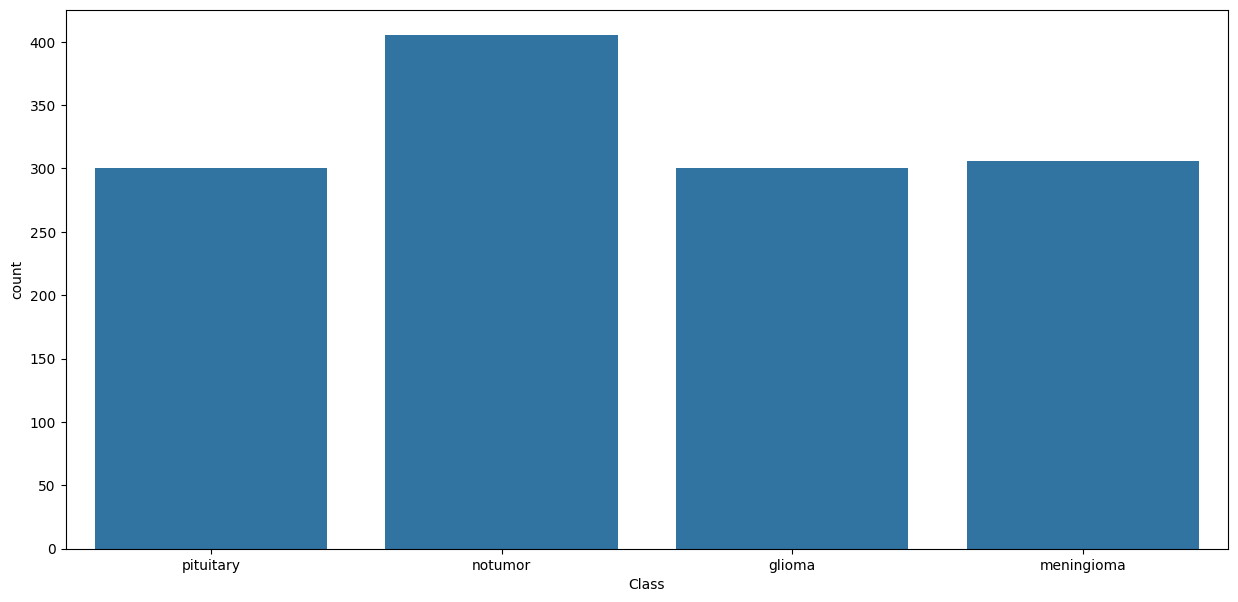

In [8]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# stratify split - porpotion will be presearved in training and testing dataset
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])
# valid_df
# ts_df

In [11]:
batch_size = 32

img_size = (299, 299)

# rescale the image
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [12]:
tr_gen = image_generator.flow_from_dataframe(
    tr_df, x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df, x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size
)

ts_gen = image_generator.flow_from_dataframe(
    ts_df, x_col='Class Path', 
    y_col='Class', 
    batch_size=16, 
    target_size=img_size, shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


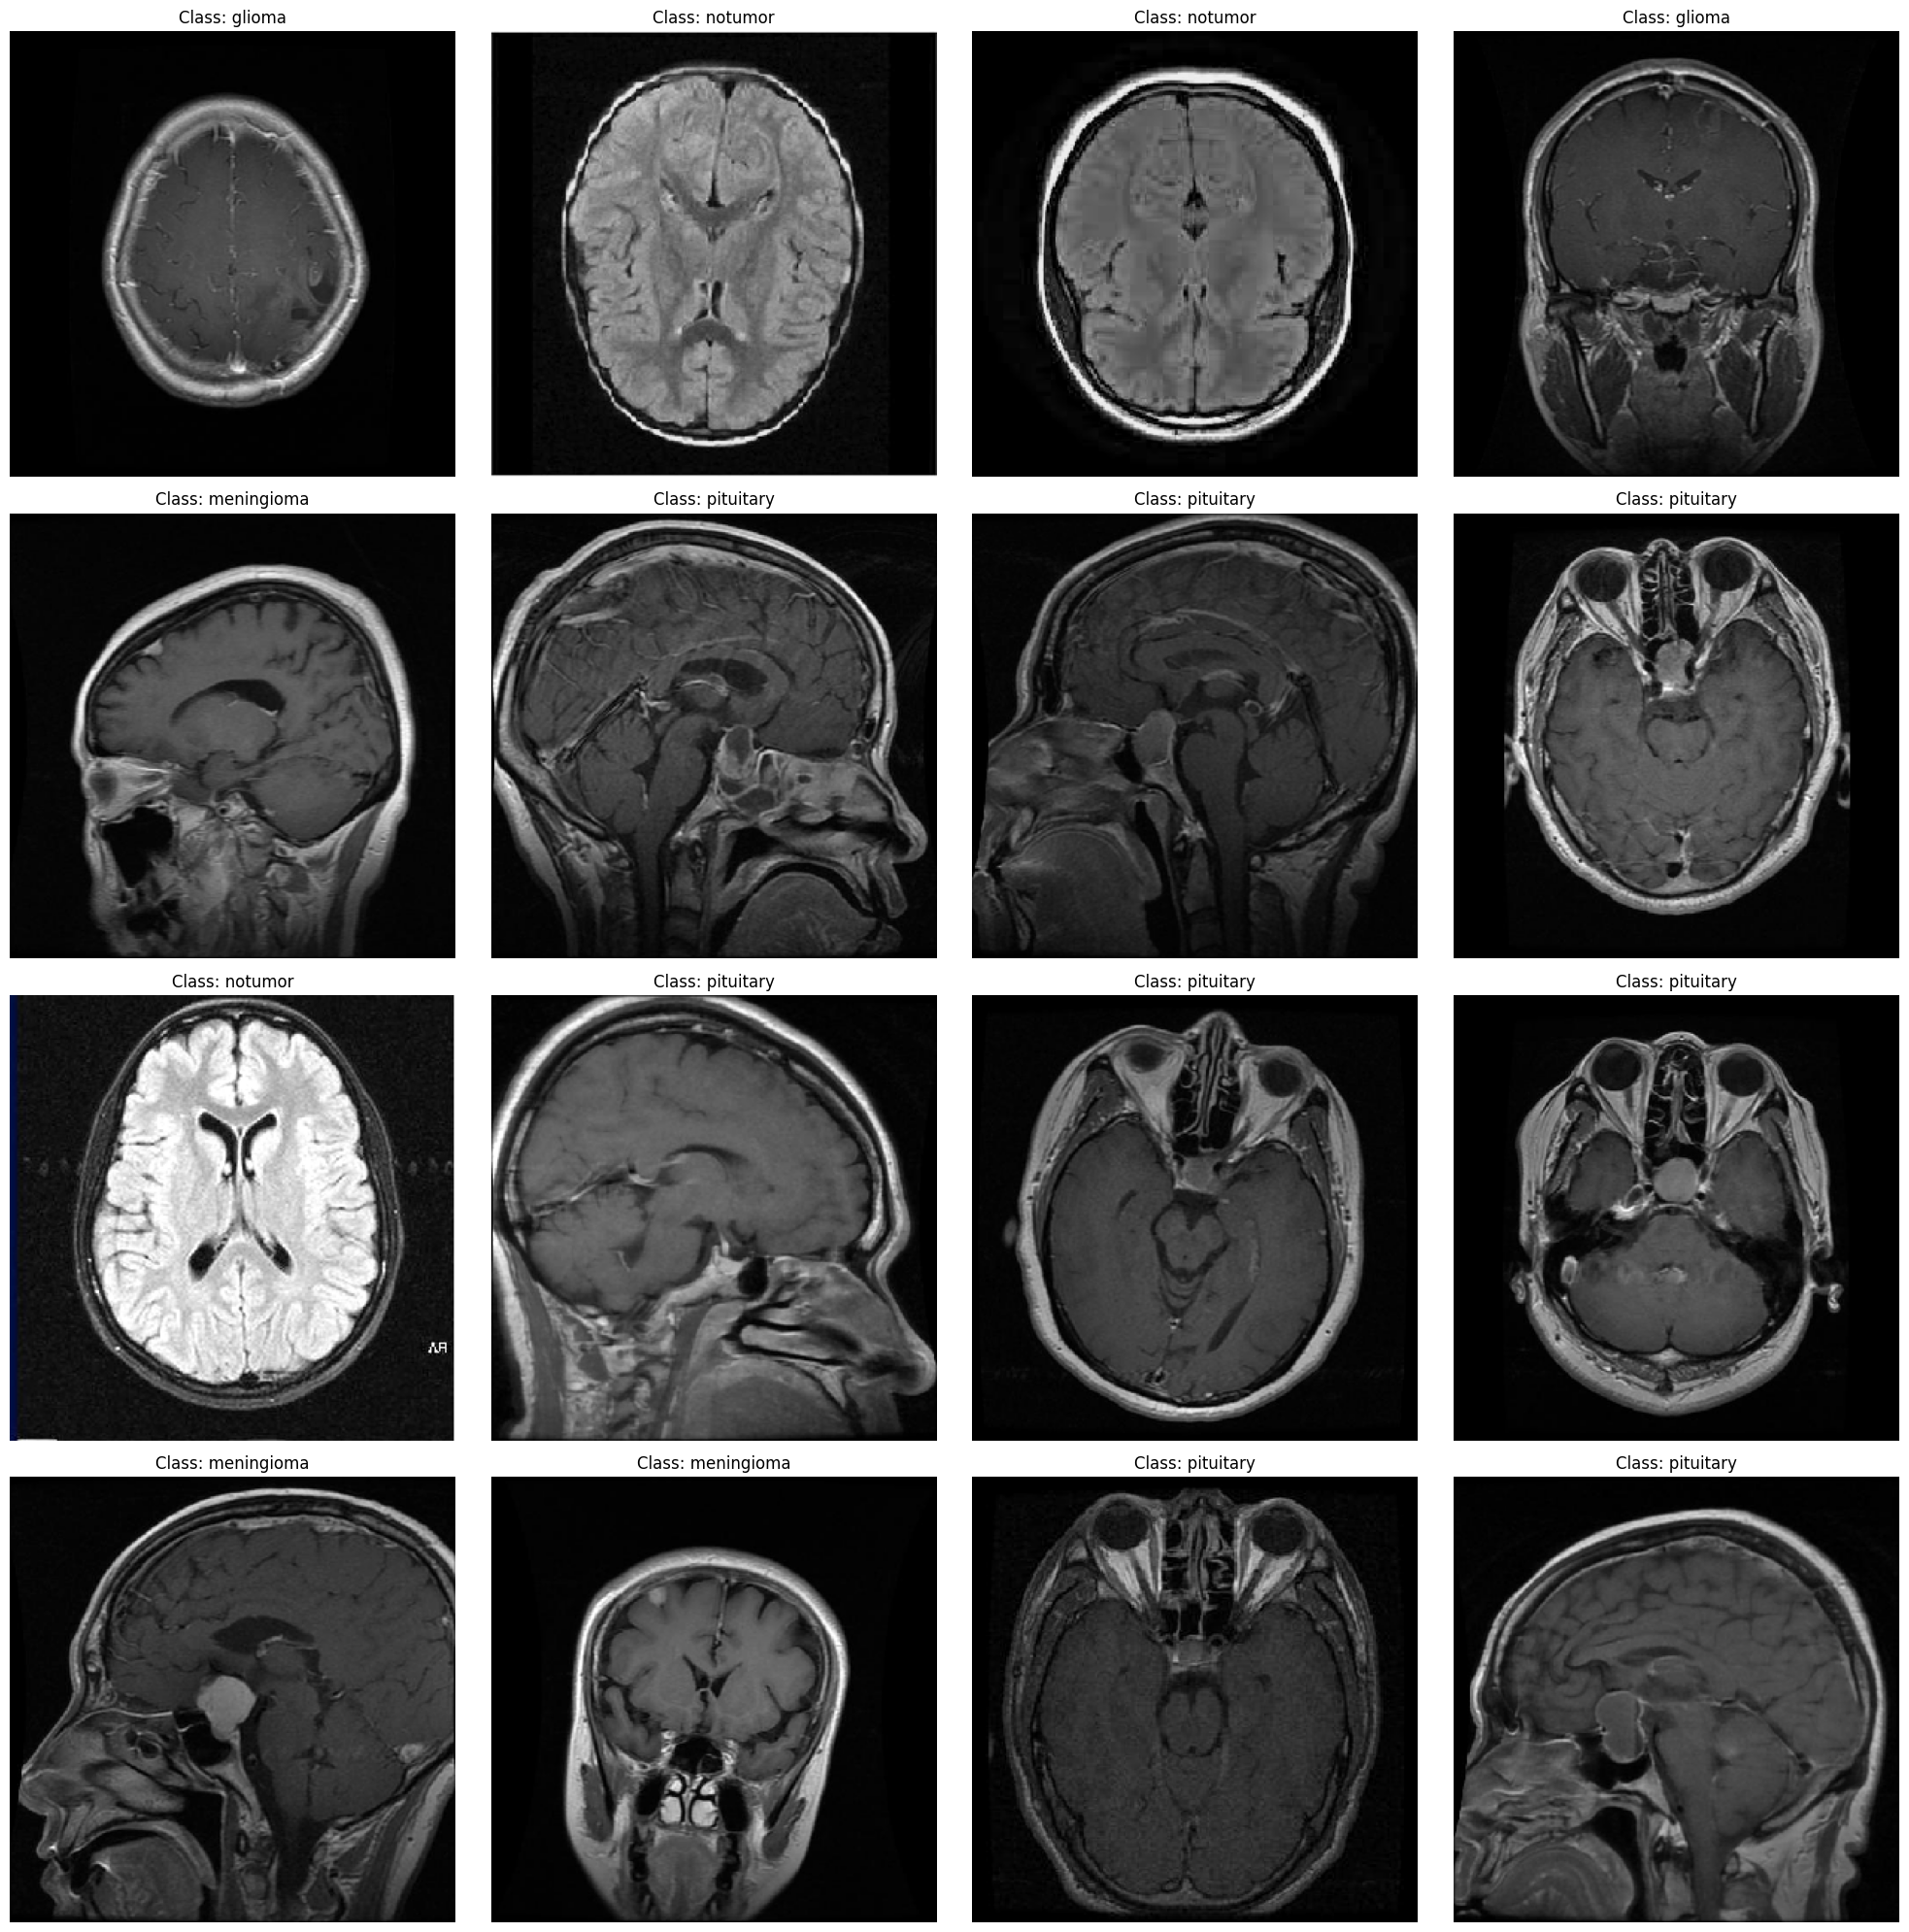

In [13]:
plt.figure(figsize=(20, 20))
for i in range(16): 
    plt.subplot(4, 4, i+1)
    batch = next(tr_gen)
    image = batch[0][0]
    label = batch[1][0]
    plt.imshow(image)

    class_index = np.argmax(label)

    class_names = list(tr_gen.class_indices.keys())
    class_indices = list(tr_gen.class_indices.values())

    index_position = class_indices.index(class_index)

    class_name = class_names[index_position]

    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=img_shape, 
    pooling='max'
)

2024-12-05 23:59:03.183601: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-05 23:59:03.183648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-05 23:59:03.183651: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-05 23:59:03.183934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-05 23:59:03.183954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
model = Sequential([
    base_model, 
    Flatten(), 
    Dropout(rate=0.3), 
    Dense(128, activation='relu'), 
    Dropout(rate=0.25), 
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy', 
                     Precision(), 
                     Recall()])

### Running with GPU and CPU comparison
![title](GPU-CPU-comparison.jpg)


In [25]:
# epoch = 5 means model goes through the entire dataset 5 times. 5 pass in training data. 
# each pass time update the weights. USE GPU here. 
# with tf.device('/CPU:0'):
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.9077 - loss: 0.2746 - precision: 0.9177 - recall: 0.8954 - val_accuracy: 0.9084 - val_loss: 0.2589 - val_precision: 0.9122 - val_recall: 0.9038
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 475s 3s/step - accuracy: 0.9782 - loss: 0.0763 - precision: 0.9799 - recall: 0.9771 - val_accuracy: 0.9344 - val_loss: 0.2124 - val_precision: 0.9382 - val_recall: 0.9267
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.9890 - loss: 0.0362 - precision: 0.9894 - recall: 0.9878 - val_accuracy: 0.9939 - val_loss: 0.0291 - val_precision: 0.9939 - val_recall: 0.9939
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 465s 3s/step - accuracy: 0.9955 - loss: 0.0165 - precision: 0.9955 - recall: 0.9951 - val_accuracy: 0.9771 - val_loss: 0.0815 - val_precision: 0.9771 - val_recall: 0.9771
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9943 - loss: 0.0197 - precision: 0.9946 - recall: 0.9943 - val_accuracy: 0.9878 - val_loss: 0.

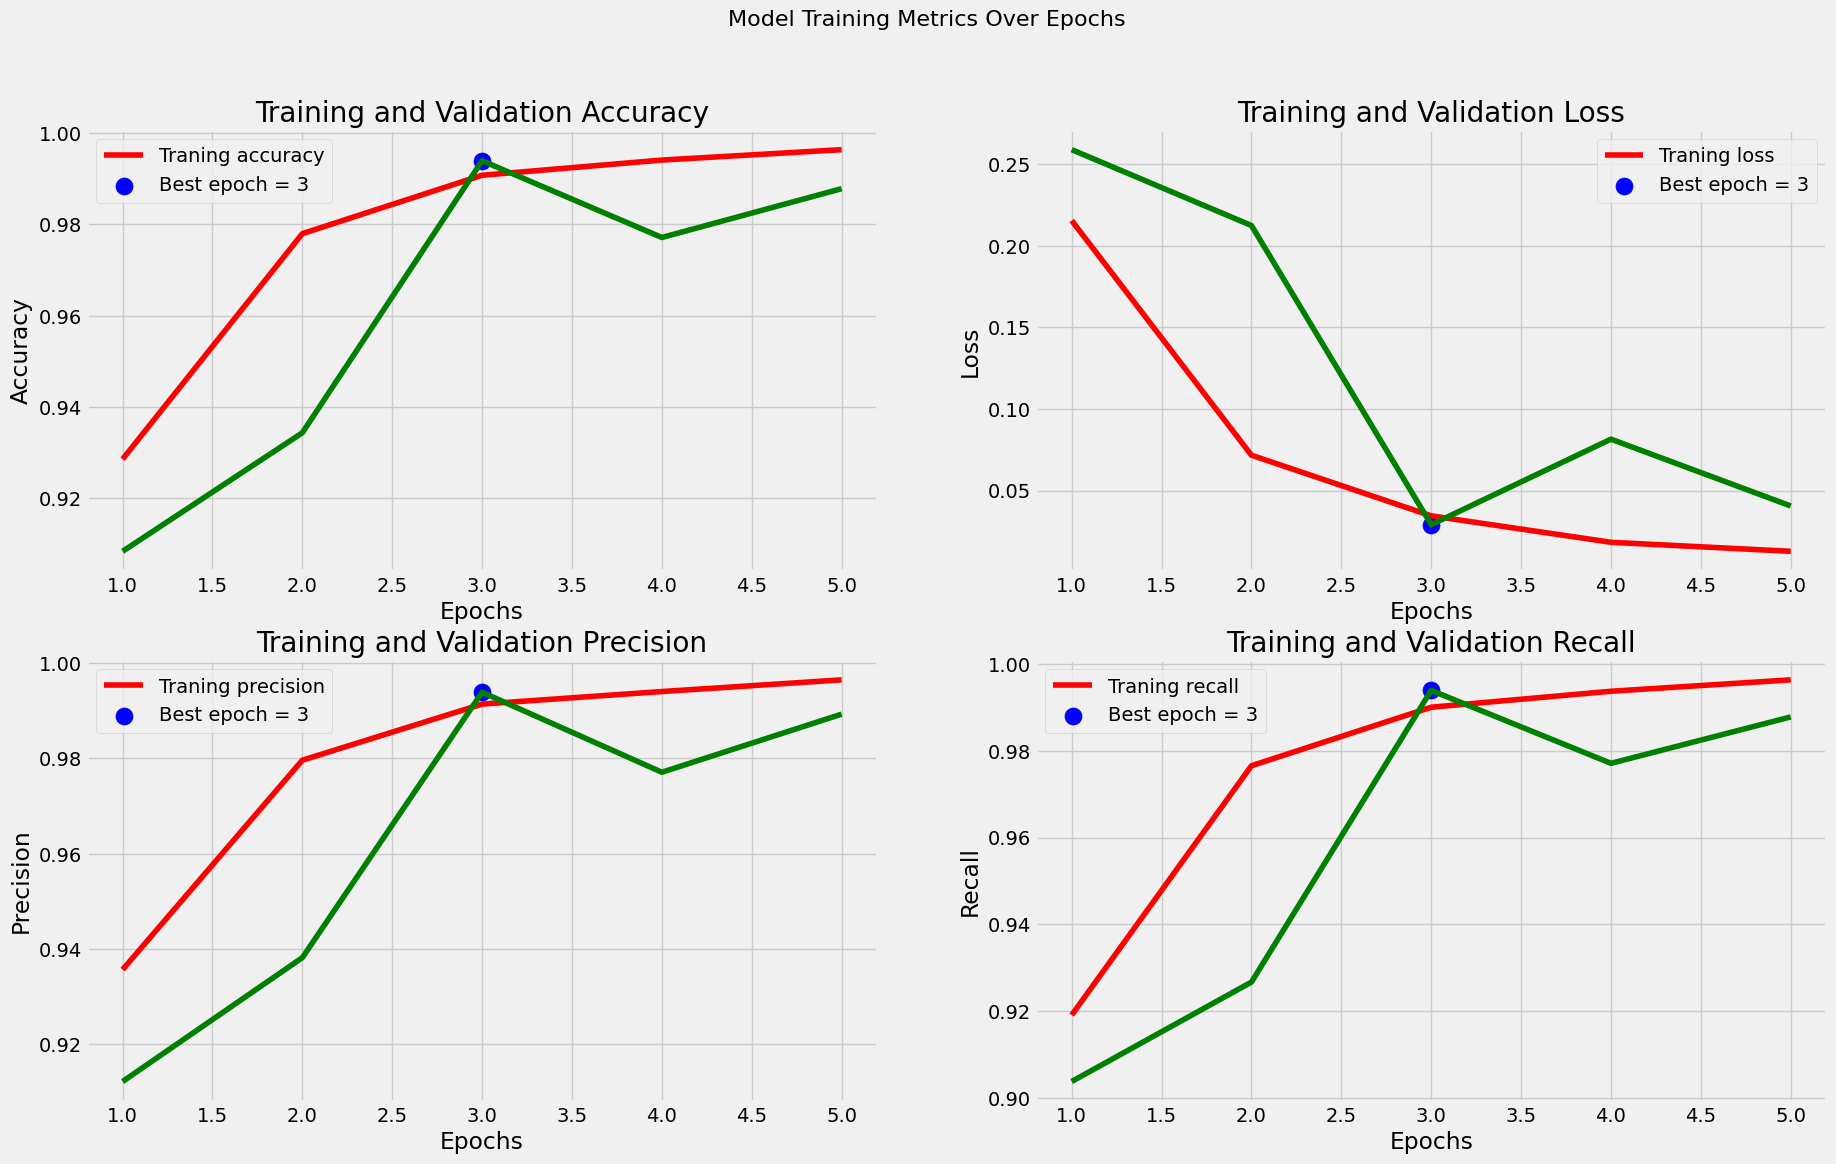

In [32]:
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics: 
    if m == 'loss': 
        idx = np.argmin(val_metrics[m])
    else: 
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1): 
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Traning {metric}')
    plt.plot(epochs, val_metrics[metric], 'g')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
                label=f'Best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# The Graph blue dot shows when the accuracy is the best


In [33]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)
# Verbose=1 we'll the process 

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}%")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 458ms/step - accuracy: 0.9961 - loss: 0.0122 - precision: 0.9961 - recall: 0.9958
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 607ms/step - accuracy: 0.9892 - loss: 0.0377 - precision: 0.9892 - recall: 0.9892


/Users/liuqiming/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.9729 - loss: 0.0948 - precision: 0.9729 - recall: 0.9729
Train Accuracy: 99.54%
Train Loss: 0.0137%


Validation Accuracy: 98.93%
Validation Loss: 0.0365


Test Accuracy: 98.02%
Test Loss: 0.0739


### Build up a confusion matrix

diagonal is the correct prediction, you can see how how many prediction is correct and which are incorrect

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step


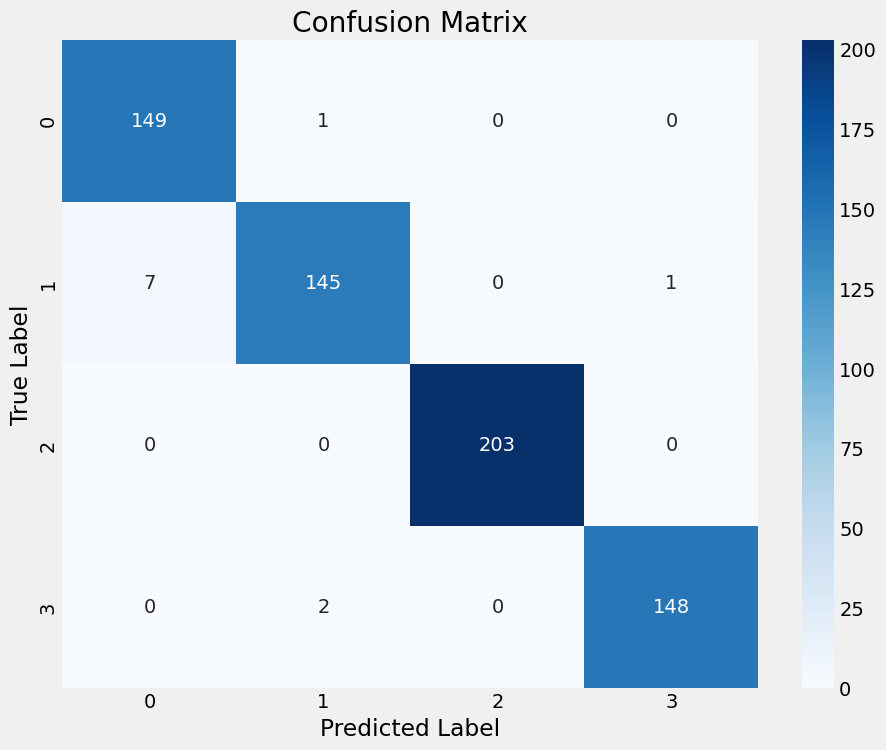

In [36]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma', 
    1: 'meningioma', 
    2: 'no_tumor', 
    3: 'pituitary'
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
from PIL import Image

def predict(img_path: str) -> None: 
    # Get the class labels
    labels = list(class_dict.keys())
    
    plt.figure(figsize=(6, 8))
    
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    predictions = model.predict(img_array)
    probabilities = list(predictions[0])
    
    predicted_class_idx = np.argmax(probabilities)
    predicted_class = class_dict[predicted_class_idx]
    
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")
    
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probabilities)
    plt.xlabel("Probability", fontsize=15)
    plt.title("Class Probabilities")
    
    ax = plt.gca()
    ax.bar_label(bars, fmt="%.2f")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


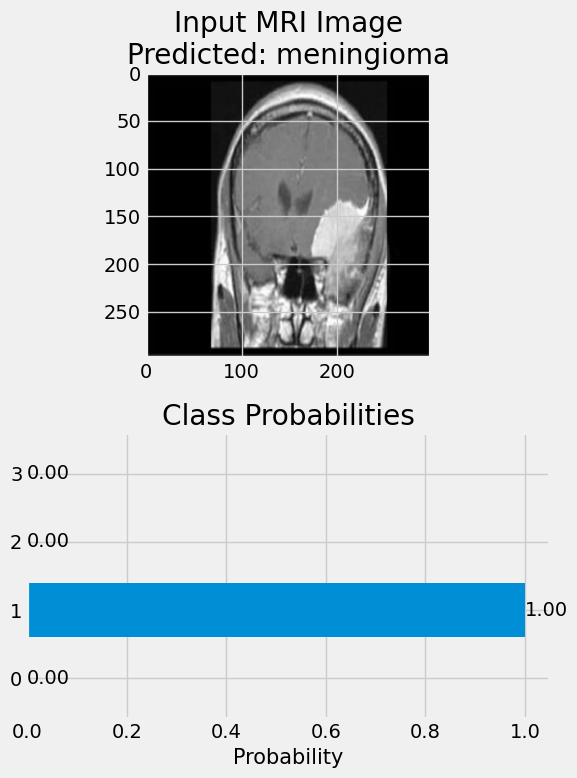


Predicted tumor type: meningioma


In [50]:
predict("Testing/meningioma/Te-meTr_0000.jpg")

In [51]:
model.save_weights("xception_model.weights.h5")

### Cheaper by developing a simpler CNN model and has same accuracy? 

#### Approches
Few batch_size means fewer images are being processed at the same time. 

Dropot layers is randomly dropping out some connections to prevent overfitting

Flatten is making all networks on 1 line

#### Best practices

number of neurons in each layer can be power of 2

changing layers arrangements, number of neurons, etc


In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [17]:
batch_size = 16

img_size = (224, 224)

# rescale the image
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = image_generator.flow_from_dataframe(
    tr_df, x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df, x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size
)

ts_gen = image_generator.flow_from_dataframe(
    ts_df, x_col='Class Path', 
    y_col='Class', 
    batch_size=16, 
    target_size=img_size, shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [18]:
cnn_model = Sequential()

cnn_model.add(Conv2D(512, (3,3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax'))

cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

cnn_model.summary()

/Users/liuqiming/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = cnn_model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/Users/liuqiming/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 288s 785ms/step - accuracy: 0.5555 - loss: 2.3575 - precision_3: 0.6878 - recall_3: 0.3529 - val_accuracy: 0.7496 - val_loss: 0.9067 - val_precision_3: 0.7926 - val_recall_3: 0.6824
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 259s 724ms/step - accuracy: 0.8021 - loss: 0.7434 - precision_3: 0.8269 - recall_3: 0.7664 - val_accuracy: 0.7802 - val_loss: 0.6811 - val_precision_3: 0.8190 - val_recall_3: 0.7389
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 256s 717ms/step - accuracy: 0.8493 - loss: 0.5478 - precision_3: 0.8672 - recall_3: 0.8286 - val_accuracy: 0.8611 - val_loss: 0.4969 - val_precision_3: 0.8696 - val_recall_3: 0.8351
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 273s 764ms/step - accuracy: 0.8871 - loss: 0.4280 - precision_3: 0.8964 - recall_3: 0.8809 - val_accuracy: 0.8504 - val_loss: 0.5178 - val_precision_3: 0.8585 - val_recall_3: 0.8336
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 317s 887ms/step - accuracy: 0.9040 - loss: 0.3923 - precision_3: 0.9112 - recall_3: 0.8

### Visualize the history result

In [73]:
# history.history

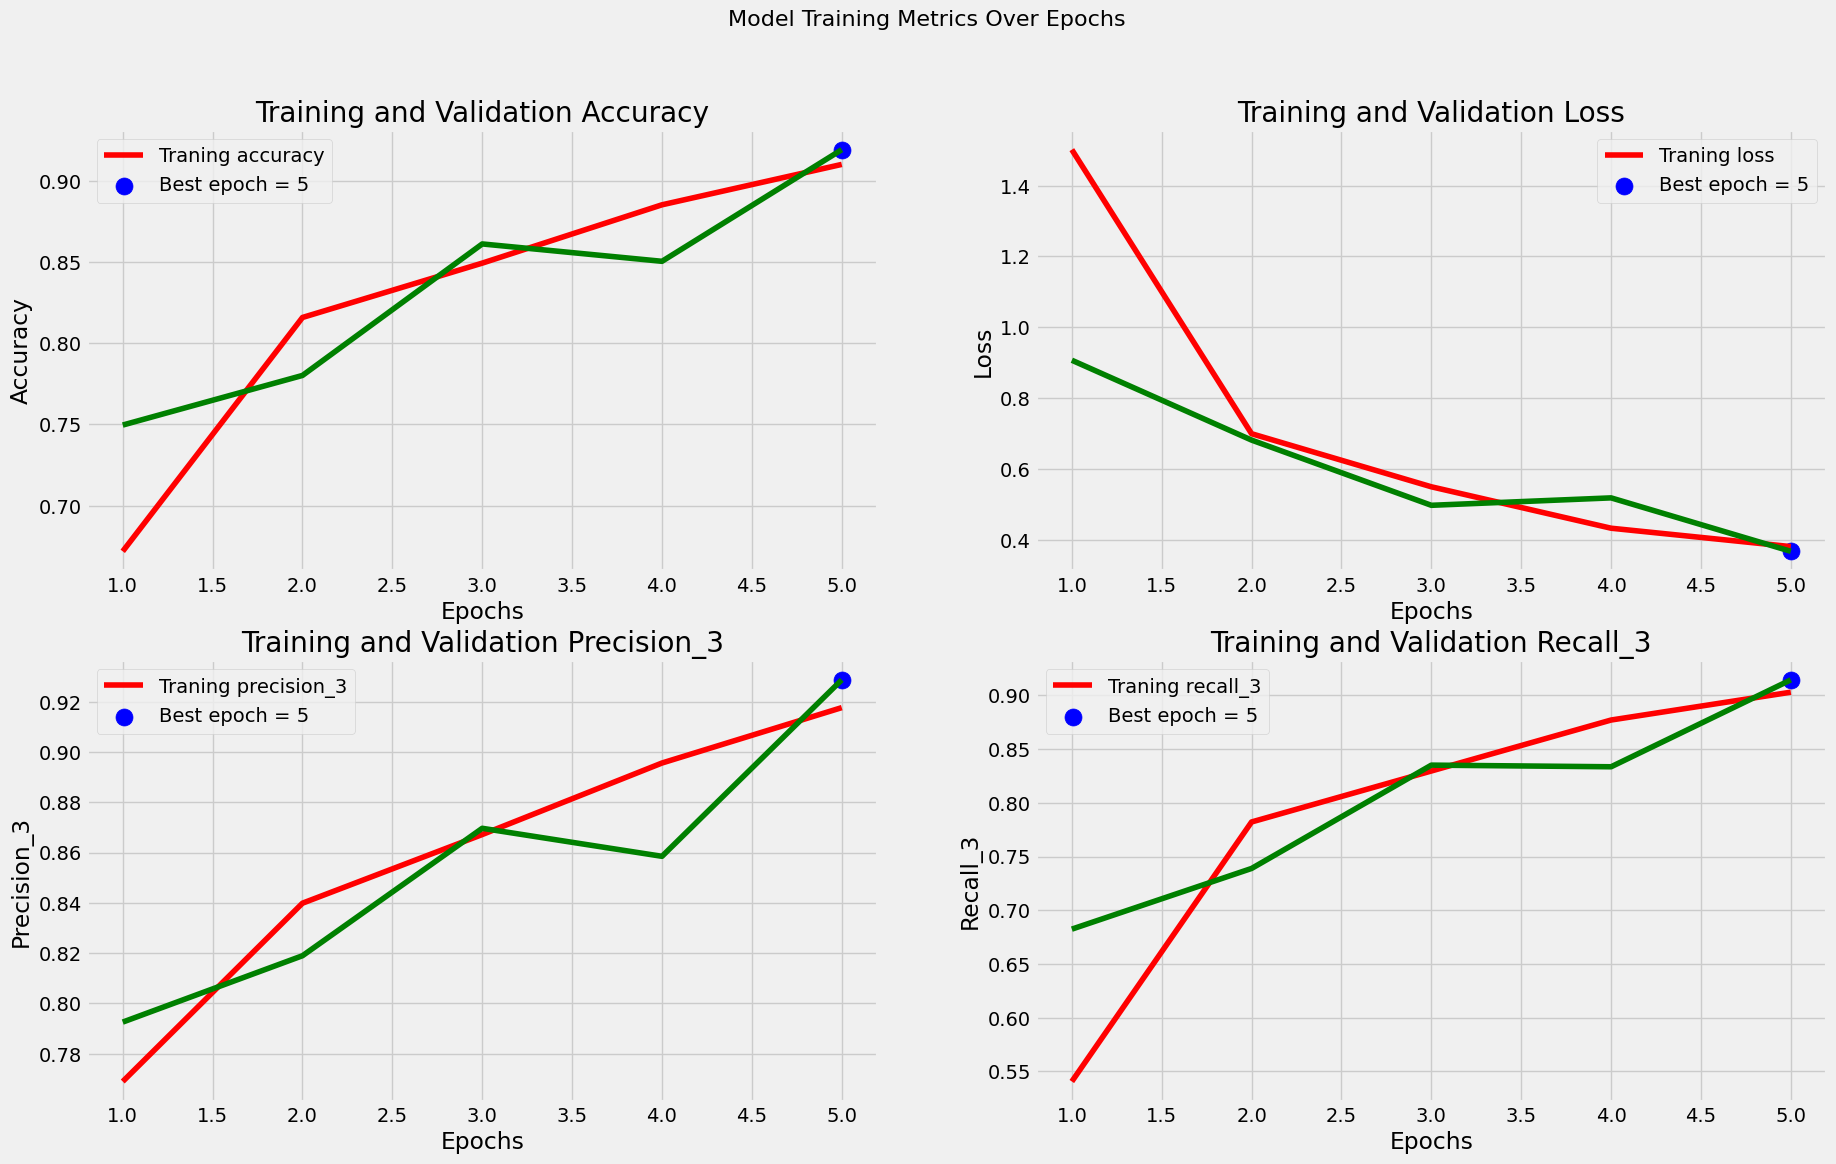

In [72]:
# metrics = ['accuracy', 'loss', 'precision', 'recall']
metrics = ['accuracy', 'loss', 'precision_3', 'recall_3']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics: 
    if m == 'loss': 
        idx = np.argmin(val_metrics[m])
    else: 
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1): 
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Traning {metric}')
    plt.plot(epochs, val_metrics[metric], 'g')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
                label=f'Best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# The Graph blue dot shows when the accuracy is the best


In [74]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)
# Verbose=1 we'll the process 

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}%")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 65s 177ms/step - accuracy: 0.9555 - loss: 0.2844 - precision_3: 0.9609 - recall_3: 0.9515
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.9328 - loss: 0.3646 - precision_3: 0.9383 - recall_3: 0.9259


/Users/liuqiming/.pyenv/versions/3.10.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9218 - loss: 0.3683 - precision_3: 0.9255 - recall_3: 0.9159
Train Accuracy: 95.19%
Train Loss: 0.2883%


Validation Accuracy: 92.21%
Validation Loss: 0.3692


Test Accuracy: 91.16%
Test Loss: 0.3780


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step


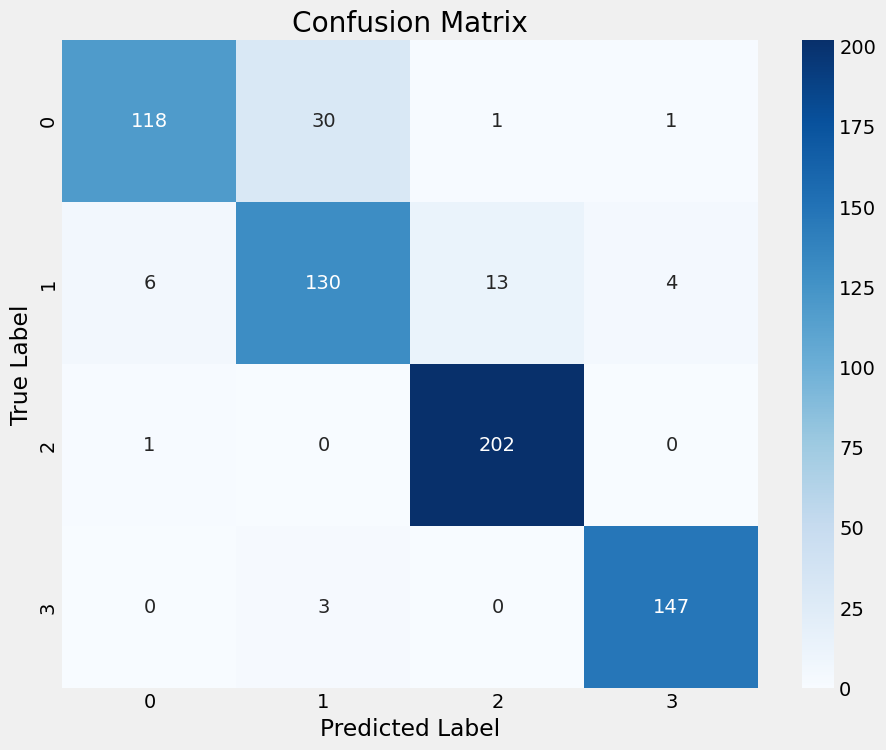

In [75]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma', 
    1: 'meningioma', 
    2: 'no_tumor', 
    3: 'pituitary'
}

cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [79]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       150
           1       0.80      0.85      0.82       153
           2       0.94      1.00      0.96       203
           3       0.97      0.98      0.97       150

    accuracy                           0.91       656
   macro avg       0.91      0.90      0.90       656
weighted avg       0.91      0.91      0.91       656



In [80]:
cnn_model.save("cnn_model.h5")

# Part 2: Streamlit Web App

In [81]:
!pip install streamlit pyngrok python-dotenv

python3(37519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 15.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 14.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.7 MB/s eta 0:00:00a 0:00:01
Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
# streamlit servez runs on different thread
from threading import Thread
from pyngrok import ngrok

## Add and load api key

In [30]:
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env")

# Fetch the API key
ngrok_key = os.getenv("NGROK_API_KEY")

# print(ngrok_key)

In [31]:
def run_streamlit(): 
    os.system("streamlit run app.py --server.port 8501")

In [32]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from PIL import Image
import os
from dotenv import load_dotenv
import google.generativeai as genai

# Load environment variables
load_dotenv()

output_dir = "saliency_maps"
os.makedirs(output_dir, exist_ok=True)

def generate_saliency_map(model, img_array, class_index, img_size): 
    with tf.GradientTape() as tape: 
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]

    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    gradients = cv2.resize(gradients, img_size)

    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y-center[1])**2 <= radius**2

    gradients = gradients * mask

    brain_gradients = gradients[mask]

    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min(): 
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, img_size)

    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, upload_file.name)
    with open(img_path, "wb") as f: 
        f.write(upload_file.getbuffer())

    saliency_map_path = f"saliency_maps/{upload_file.name}"

    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img


def load_xception_model(model_path): 
    img_shape=(299, 299, 3)
    base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                               input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model, 
        Flatten(), 
        Dropout(rate=0.3), 
        Dense(128, activation='relu'), 
        Dropout(rate=0.25), 
        Dense(4, activation='softmax')
    ])

    model.build((None,) + img_shape)

    model.compile(Adamax(learning_rate=0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy', 
                             Precision(), 
                             Recall()])
    model.load_weights(model_path)

    return model

# Streamlit application setup
st.title("Brain Tumor Classification")

st.write("Upload an image of a brain MRI scan to classify.")

upload_file = st.file_uploader("Choose an image...", type=['jpg', 'jpeg', 'png'])

if upload_file is not None: 
    selected_model = st.radio(
        "Select Model", 
        ("Transfer Learning - Xception", "Custom CNN")
    )

    if selected_model == "Transfer Learning - Xception": 
        model = load_xception_model('xception_model.weights.h5')
        img_size = (299, 299)
    else: 
        model = load_model('cnn_model.h5')
        img_size = (224, 224)

    labels = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']
    img = image.load_img(upload_file, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    class_index = np.argmax(prediction[0])
    result = labels[class_index]

    st.write(f"Predicted Class: {result}")
    st.write("Predictions:")
    for label, prob in zip(labels, prediction[0]): 
        st.write(f"{label}: {prob:.4f}")

    saliency_map = generate_saliency_map(model, img_array, class_index, img_size)
    
    col1, col2 = st.columns(2)
    with col1: 
        st.image(upload_file, caption="Uploaded Image", use_column_width=True)
    with col2: 
        st.image(saliency_map, caption="Saliency Map", use_column_width=True)

Overwriting app.py


In [33]:
# New thread to run streamlit on background
thread = Thread(target=run_streamlit)
thread.start()

In [34]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)

print(public_url)


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.18.169.254:8501

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
NgrokTunnel: "https://b561-216-165-95-176.ngrok-free.app" -> "http://localhost:8501"


2024-12-06 00:00:19.590 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registered via torch::class_


## Managing background ngrox process

### Checking background ngrox running process
`ps aux | grep ngrok`

### Visit Ngrox console

Note: it's read-only api endpoint. To kill tunnel, do it programmingly or in terminal

http://127.0.0.1:4040/inspect/http

In [141]:
!ps aux | grep ngrok

liuqiming        69662   0.2  0.2 410087456  26240   ??  S     9:54PM   0:16.57 /Users/liuqiming/Library/Application Support/ngrok/ngrok start --none --log=stdout
liuqiming        11903   0.0  0.0 407966112    176 s003  R+   10:56PM   0:00.00 grep ngrok
liuqiming        11900   0.0  0.0 408787504   2944 s003  Ss+  10:56PM   0:00.01 /bin/zsh -c ps aux | grep ngrok


python3(11900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [142]:
from pyngrok import ngrok

tunnels = ngrok.get_tunnels()

for tunnel in tunnels:
    ngrok.disconnect(tunnel.public_url)
    print(f"Disconnected tunnel: {tunnel.public_url}")

Disconnected tunnel: https://06e0-216-165-95-165.ngrok-free.app
Disconnected tunnel: https://f427-216-165-95-165.ngrok-free.app
Disconnected tunnel: https://b269-216-165-95-165.ngrok-free.app


## Model continue

2024-11-16 22:34:28.708 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.711 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.712 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-16 22:34:28.713 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar